# Description

Here we introduce a Network for solving pressure poisson 

The network is a Convolutional Neural Network with 5 layers. at some point it splits in three branches because of two subsequent pooling (max)

Each convolutional layer has a filter size of 3x3

In [1]:
import keras as keras
from keras import layers, models
import tensorflow as tf
import numpy as np

2025-07-02 17:26:04.552075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 17:26:05.018458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751469965.194892     616 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751469965.241308     616 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751469965.590546     616 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Import the dataset

In [2]:
# Improved version
import os
import shutil
from myPackageUtils.dataset_utils import load_dataset

dataset_folder = "saved_data"
path = (os.path.join(os.getcwd(), dataset_folder))
dataset = load_dataset(path)

dataset_size = dataset.cardinality().numpy()

print(dataset_size)

def preprocess(image, label):
    image = tf.expand_dims(input=image, axis=0)
    label = tf.expand_dims(input=label, axis=0)
    return image, label

# Reshape tensor
dataset = dataset.map(preprocess)

ds_train = dataset.take(0.8*dataset_size)
ds_test = dataset.skip(0.8*dataset_size)

print(ds_test.cardinality())
print(ds_train.cardinality())

for (a,b) in ds_test.take(1):
    print(a.shape, b.shape)

Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset9


I0000 00:00:1751469971.998665     616 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset5
Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset3
Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset8
Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset4
Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset2
Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset0
Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset1
Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset7
Loading dataset from:  /home/peppe/documents/pressure-net-2d/saved_data/dataset6
10000
tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(8000, shape=(), dtype=int64)
(1, 128, 128, 1) (1, 128, 128, 1)


2025-07-02 17:26:18.653928: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Network structure
load the model from packages

In [3]:
from importlib import reload
import n2_model.make_model as mm
reload(mm)

from importlib import reload
import n2_model.custom_loss as c_loss
reload(c_loss)

custom_loss = c_loss.f_obj(1,1)
# NOTE: for now the network is trained with no obstacle whatsover
model = mm.make_model((128,128,1))

model.summary()
model.compile(optimizer='adam',
              loss=custom_loss,
              )

# keras.utils.plot_model(model, "Pressure_CNN.png")

Model: "MyModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │         80 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 64, 64, 8) │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 32, 32, 8) │          0 │ average_pooling2… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64, 8) │        584 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32, 8) │        584 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (Resizing)          │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        584 │ conv2d[0][0]      │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ resizing[0][0],   │
│                     │ 8)                │            │ resizing_1[0][0], │
│                     │                   │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │         72 │ add[0][0]         │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │          9 │ conv2d_4[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,913 (7.47 KB)

 Trainable params: 1,913 (7.47 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model and save it

In [ ]:
history = model.fit(ds_train, validation_data=ds_test, epochs=50)

Epoch 1/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 5.8665 - val_loss: 5.8069
Epoch 2/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 5.8557 - val_loss: 5.7940
Epoch 3/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - loss: 5.8450 - val_loss: 5.7825
Epoch 4/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 5.8348 - val_loss: 5.7728
Epoch 5/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 5.8256 - val_loss: 5.7660
Epoch 6/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 5.8167 - val_loss: 5.7555
Epoch 7/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 5.8071 - val_loss: 5.7391
Epoch 8/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 5.7981 - val_loss: 5.7316
Epoch 9/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 5.7889 - val_loss: 5.7245
Epoch 10/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 5.7820 - val_loss: 5.7213
Epoch 11/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 5.7750 - val_loss: 5.7150
Epoch 12/50
8000/80

dict_keys(['loss', 'val_loss'])
[16.823057174682617, 9.146025657653809, 8.662856101989746, 8.237322807312012, 7.960336685180664, 7.783969879150391, 7.668277740478516, 7.5766401290893555, 7.472772598266602, 7.335965156555176, 7.215147018432617, 7.134957313537598, 7.065241813659668, 7.003739833831787, 6.944454193115234, 6.87813138961792, 6.8153839111328125, 6.7557220458984375, 6.670541286468506, 6.779777526855469, 6.737584114074707, 6.681924343109131, 6.630703926086426, 6.586088180541992, 6.54763650894165, 6.505773067474365, 6.465457916259766, 6.429029941558838, 6.3974409103393555, 6.36663818359375, 6.337507247924805, 6.310722351074219, 6.284835338592529, 6.256391525268555, 6.217305660247803, 6.168458938598633, 6.128281593322754, 6.09880256652832, 6.075010299682617, 6.052859783172607, 6.032375335693359, 6.013547420501709, 5.996827602386475, 5.981661796569824, 5.966330528259277, 5.951173782348633, 5.936195373535156, 5.923951148986816, 5.912148952484131, 5.9011735916137695]
[8.995981216430

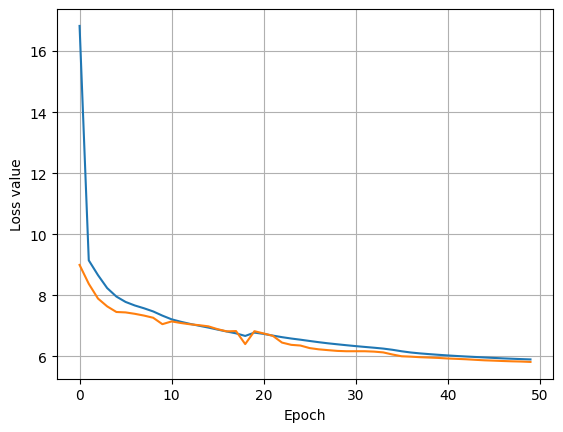

In [6]:
# Print history
import matplotlib.pyplot as plt
print(history.history.keys())

plt.plot(history.history['loss'], label="test loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss value")

print(history.history['loss'])
print(history.history['val_loss'])

In [ ]:
# Eventually save
save_flag = False

if save_flag:
    path_model = "4_pressure_solution_NET/SAVED_MODEL.keras"
    model.save(path_model)

# Simulate of a feedforward on trained network

tf.Tensor(0.22251442, shape=(), dtype=float32)


/tmp/ipykernel_616/832206377.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  t1 = spatial_filter(random_noise1, char_len=2).astype(np.double)


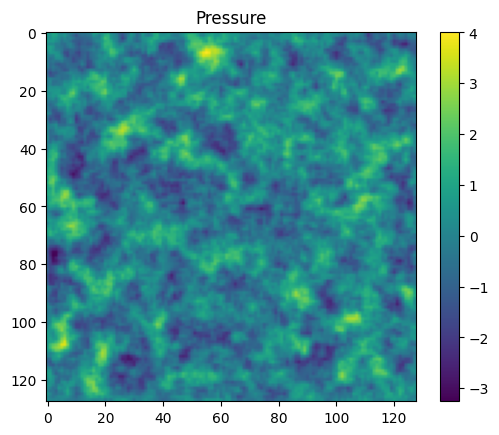

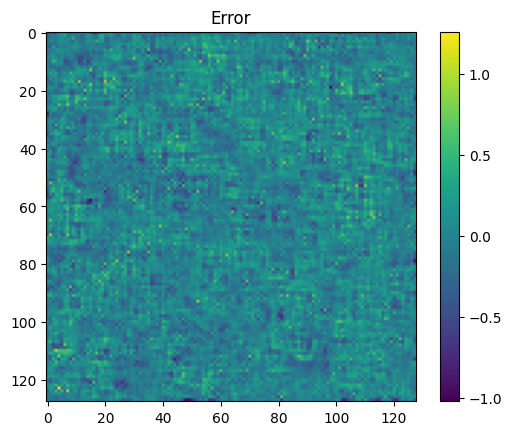

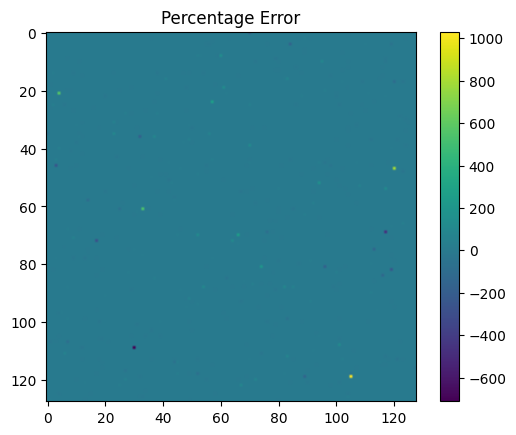

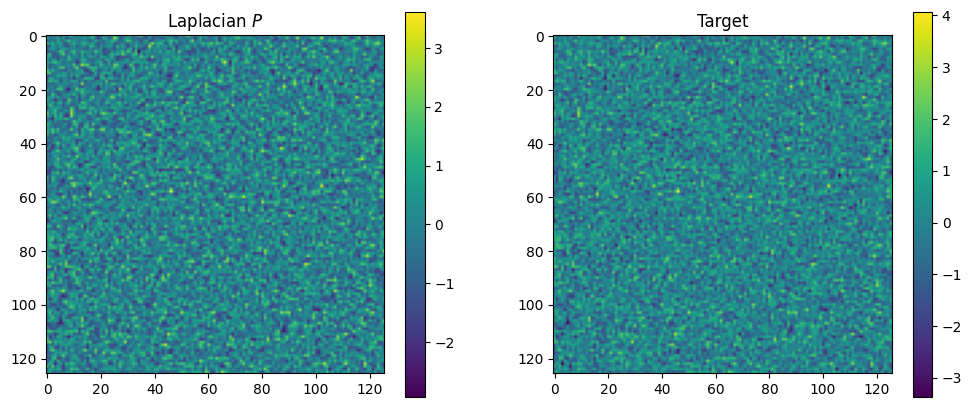

In [12]:
# std is 1.
# The dataset has been trained with std to be 0.2
p_true = tf.random.normal((1,128,128,1))
std = tf.math.reduce_std(p_true)
p_true = p_true / (std*20)

L = tf.constant(
    [[0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]], dtype=tf.float32)
L = tf.reshape(L, [3,3,1,1])

t1 = tf.nn.convolution(p_true, L, padding="SAME")
t1_dev = tf.math.reduce_std(t1)
print(t1_dev)
t1 = tf.random.normal((1,128,128,1)) * (0.2 / t1_dev)   # normalize standard deviation

from myPackageUtils.spatial_filter import spatial_filter
(N_x, N_y) = (128, 128)
random_noise1 = np.random.normal(size=(N_x, N_y))
t1 = spatial_filter(random_noise1, char_len=2).astype(np.double)
t1 = tf.constant(t1.reshape((1,N_x, N_y,1)), dtype=tf.float32)

p_out = model(t1)

lap_p = tf.nn.convolution(p_out, L, padding="SAME")

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(p_out[0,:,:,0])
plt.title("Pressure")
plt.colorbar()
# First figure
plt.figure()
plt.imshow( lap_p[0,:,:,0] - t1[0,:,:,0] ) 
plt.title("Error")
plt.colorbar()

plt.figure()
plt.imshow( tf.divide((lap_p[0,:,:,0] - t1[0,:,:,0]), t1[0,:,:,0]) )
plt.title("Percentage Error")
plt.colorbar()
# Second figure
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow( lap_p[0,1:-1,1:-1,0])
plt.title("Laplacian $P$")
plt.colorbar()
plt.subplot(1,2,2)
plt.title("Target")
plt.imshow( t1[0,1:-1,1:-1,0])
plt.colorbar()
# plt.imshow(t1[0,:,:,0])